In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import netCDF4 as nc

import sys
sys.path.append('../../')

import utils as s3u
from parallel_get_xy_poly import ParallelCoord
from nc_explorer import NcExplorer
from tsgen import TsGenerator

gpc = ParallelCoord()
tsg = TsGenerator()
# exp = NcExplorer()

sen3r-NcExplorer: from mpl_toolkits.basemap import Basemap FAILED!
You can still proceed without plotting any maps.



## TESTING SUN AND OBS ANGLES FOR GLINT

In [17]:
def get_glint(df):
    """
    Calculates glint angle based on paper:
    An Enhanced Contextual Fire Detection Algorithm for MODIS
    https://www.sciencedirect.com/science/article/pii/S0034425703001846
    https://doi.org/10.1016/S0034-4257(03)00184-6
    """

    df['GLINT'] = np.degrees(np.arccos(np.cos(np.deg2rad(df['OZA'])) *
                                       np.cos(np.deg2rad(df['SZA'])) -
                                       np.sin(np.deg2rad(df['OZA'])) *
                                       np.sin(np.deg2rad(df['SZA'])) *
                                       np.cos(np.deg2rad(abs(df['SAA'] - df['OAA'])))))

    # excel version
    # =GRAUS(ACOS(COS(RADIANOS(OZA))*COS(RADIANOS(SZA))-SEN(RADIANOS(OZA))*SEN(RADIANOS(SZA))*COS(RADIANOS(ABS(SAA-OAA)))))

    return df

## SYN

In [4]:
# path = Path('/d_drive_data/S3/SY_2_SYN/S3A_SY_2_SYN____20191104T135002_20191104T135302_20191106T033418_0180_051_124_3060_LN2_O_NT_002.SEN3')
# exp = NcExplorer(input_nc_folder=path, product='syn')

## WFR

In [3]:
path = Path('/d_drive_data/S3/L2_WFR/S3A_OL_2_WFR____20191104T135002_20191104T135302_20191124T134508_0179_051_124_3060_MAR_O_NT_002.SEN3')
exp = NcExplorer(input_nc_folder=path, product='wfr')

Declaring class instance from: SEN3R:nc_explorer
Reading valid NetCDF files inside image folder...
Product set to WFR.
Loading image bands into memory, this may take a while...


In [5]:
# Create a list with all valid NetCDF4 files
ncfs = exp.get_valid_band_files(rad_only=False)
ncfs

['chl_nn.nc',
 'chl_oc4me.nc',
 'geo_coordinates.nc',
 'instrument_data.nc',
 'iop_nn.nc',
 'iwv.nc',
 'Oa01_reflectance.nc',
 'Oa02_reflectance.nc',
 'Oa03_reflectance.nc',
 'Oa04_reflectance.nc',
 'Oa05_reflectance.nc',
 'Oa06_reflectance.nc',
 'Oa07_reflectance.nc',
 'Oa08_reflectance.nc',
 'Oa09_reflectance.nc',
 'Oa10_reflectance.nc',
 'Oa11_reflectance.nc',
 'Oa12_reflectance.nc',
 'Oa16_reflectance.nc',
 'Oa17_reflectance.nc',
 'Oa18_reflectance.nc',
 'Oa21_reflectance.nc',
 'par.nc',
 'tie_geometries.nc',
 'tie_geo_coordinates.nc',
 'tie_meteo.nc',
 'time_coordinates.nc',
 'trsp.nc',
 'tsm_nn.nc',
 'wqsf.nc',
 'w_aer.nc']

## READ BUFFER POLYGON

In [6]:
# %time xy_vertices = exp.get_xy_polygon_from_json(poly_path='/home/dvdgmf/qgis_out/manacapuru_buffer.geojson')
%time xy_vertices, ll_vertices = exp.get_xy_polygon_from_json(poly_path='/d_drive_data/downloads/manacapuru_complex.geojson')

CPU times: user 212 ms, sys: 1 s, total: 1.22 s
Wall time: 6.73 s


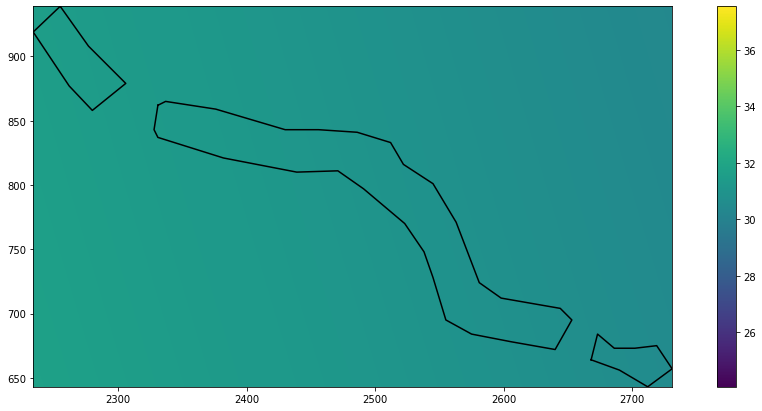

In [7]:
band = exp.SZA
bname = 'SZA'
vertices = xy_vertices

xmin, xmax, ymin, ymax = s3u.bbox(xy_vertices)

%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 7]
plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)
plt.imshow(band)
for vert in vertices:
    plt.plot(vert[:,1],vert[:,0],c='k')
plt.colorbar()
plt.show()

In [10]:
# Generate extraction mask
from skimage.draw import polygon

img = np.zeros(exp.g_lon.shape)
cc = np.ndarray(shape=(0,), dtype='int64')
rr = np.ndarray(shape=(0,), dtype='int64')

for vert in xy_vertices:
    t_rr, t_cc = polygon(vert[:,0], vert[:,1], exp.g_lon.shape)
    img[t_rr, t_cc] = 1
    cc = np.append(cc,t_cc)
    rr = np.append(rr,t_rr)

In [11]:
# Apply the mask and get the band information in the cc,rr coord pairs
band_values = band[rr, cc]

# Create a DF from the extracted reflectance
custom_subset = {bname:band_values.data,'x':rr,'y':cc}
df = pd.DataFrame(custom_subset)

df['lat'] = [exp.g_lat[x,y] for x,y in zip(df['x'],df['y'])]
df['lon'] = [exp.g_lon[x,y] for x,y in zip(df['x'],df['y'])]

df.head()

,SZA,x,y,lat,lon
0,30.780320,672,2640,-3.286901,-60.490971
1,30.791593,673,2635,-3.287086,-60.502169
2,30.789191,673,2636,-3.287692,-60.499501
3,30.786789,673,2637,-3.288297,-60.496842
4,30.784387,673,2638,-3.288297,-60.496842


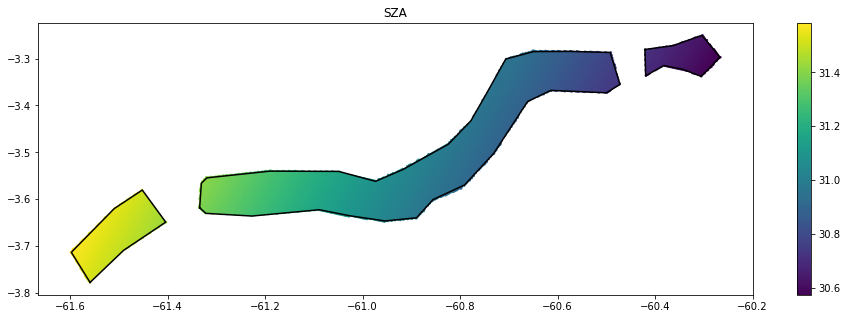

In [67]:
plt.rcParams['figure.figsize'] = [16, 5]
plt.scatter(df['lon'],df['lat'],c=df['SZA'],s=3); plt.title('SZA')
plt.colorbar()

for vert in ll_vertices:
    plt.plot(vert[:,0],vert[:,1],c='k')

plt.show()

## Get the values over the other bands as well

In [19]:
df['OAA'] = [exp.OAA[x,y] for x,y in zip(df['x'],df['y'])]
df['OZA'] = [exp.OZA[x,y] for x,y in zip(df['x'],df['y'])]
df['SAA'] = [exp.SAA[x,y] for x,y in zip(df['x'],df['y'])]

## Calculate the GLINT

In [21]:
df = get_glint(df)

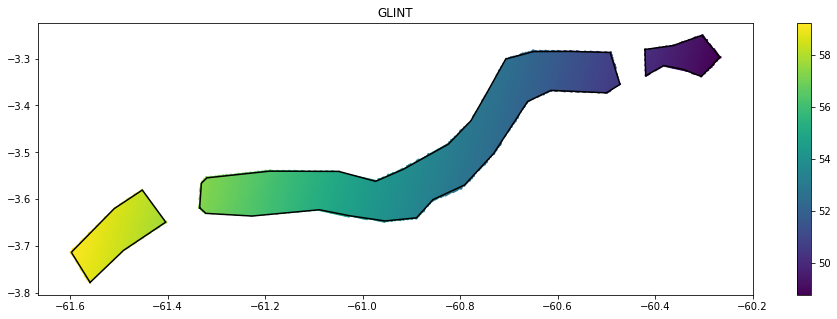

In [29]:
plt.rcParams['figure.figsize'] = [16, 5]
plt.scatter(df['lon'],df['lat'],c=df['GLINT'],s=3); plt.title('GLINT')
plt.colorbar()

for vert in ll_vertices:
    plt.plot(vert[:,0],vert[:,1],c='k')

plt.show()

## Further adding data for comparison

In [32]:
bands = {'w_aer.nc':['A865','T865'],
         'Oa06_reflectance.nc':['Oa06_reflectance'],
         'Oa17_reflectance.nc':['Oa17_reflectance'],
         'wqsf.nc':['WQSF']}

In [47]:
for k in bands:
    ds = nc.Dataset(path/k)
    for layer in bands[k]:
        band = ds[layer][:]
        df[layer] = [band[x,y] for x,y in zip(df['x'],df['y'])]

/home/dvdgmf/anaconda3/envs/gdal-qgis/lib/python3.9/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


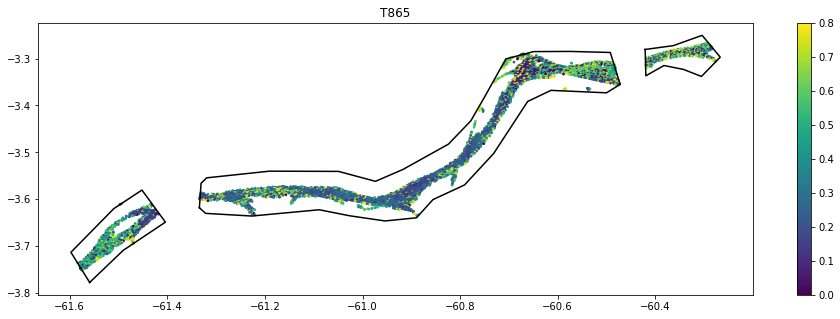

In [50]:
plt.rcParams['figure.figsize'] = [16, 5]
plt.scatter(df['lon'],df['lat'],c=df['T865'],s=3); plt.title('T865')
plt.colorbar()

for vert in ll_vertices:
    plt.plot(vert[:,0],vert[:,1],c='k')

plt.show()

In [53]:
wfr_df = df.copy()
wfr_df.head()

,SZA,x,y,lat,lon,OAA,OZA,SAA,GLINT,A865,T865,Oa06_reflectance,Oa17_reflectance,WQSF
0,30.780320,672,2640,-3.286901,-60.490971,102.708952,20.295872,115.016108,50.775122,--,--,--,--,16777220
1,30.791593,673,2635,-3.287086,-60.502169,102.709783,20.394582,115.008209,50.884498,--,--,--,--,4
2,30.789191,673,2636,-3.287692,-60.499501,102.709640,20.374837,115.008946,50.862516,--,--,--,--,4
3,30.786789,673,2637,-3.288297,-60.496842,102.709497,20.355093,115.009684,50.840534,--,--,--,--,16777220
4,30.784387,673,2638,-3.288297,-60.496842,102.709354,20.335348,115.010421,50.818552,--,--,--,--,16777220


In [54]:
glint_mtx = np.degrees(np.arccos(np.cos(np.deg2rad(exp.OZA)) * np.cos(np.deg2rad(exp.SZA)) -
                                   np.sin(np.deg2rad(exp.OZA)) * np.sin(np.deg2rad(exp.SZA)) * 
                                   np.cos(np.deg2rad(abs(exp.SAA - exp.OAA)))))
# excel version
# =GRAUS(ACOS(COS(RADIANOS(OZA))*COS(RADIANOS(SZA))-SEN(RADIANOS(OZA))*SEN(RADIANOS(SZA))*COS(RADIANOS(ABS(SAA-OAA)))))

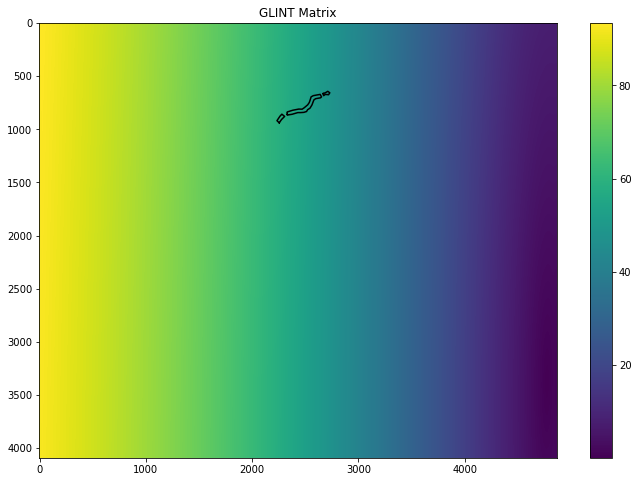

In [104]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.title('GLINT Matrix')
plt.imshow(glint_mtx)

for vert in xy_vertices:
    plt.plot(vert[:,1],vert[:,0],c='k')

plt.colorbar()
plt.show()

In [72]:
glint_2 = (glint_mtx <= 2).astype(int)
glint_8 = (glint_mtx <= 8).astype(int)
glint_12 = (glint_mtx <= 12).astype(int)

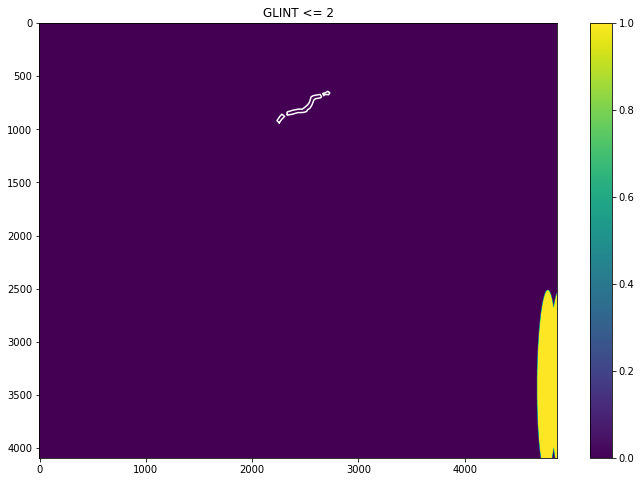

In [78]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.title('GLINT <= 2')
plt.imshow(glint_2)

for vert in xy_vertices:
    plt.plot(vert[:,1],vert[:,0],c='w')

plt.colorbar()
plt.show()

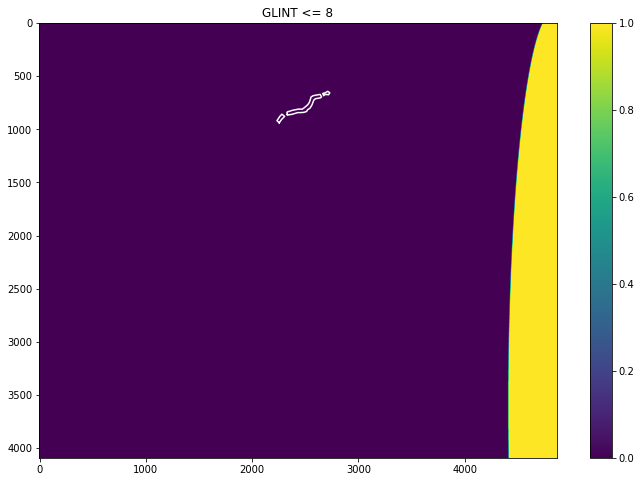

In [76]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.title('GLINT <= 8')
plt.imshow(glint_8)

for vert in xy_vertices:
    plt.plot(vert[:,1],vert[:,0],c='w')

plt.colorbar()
plt.show()

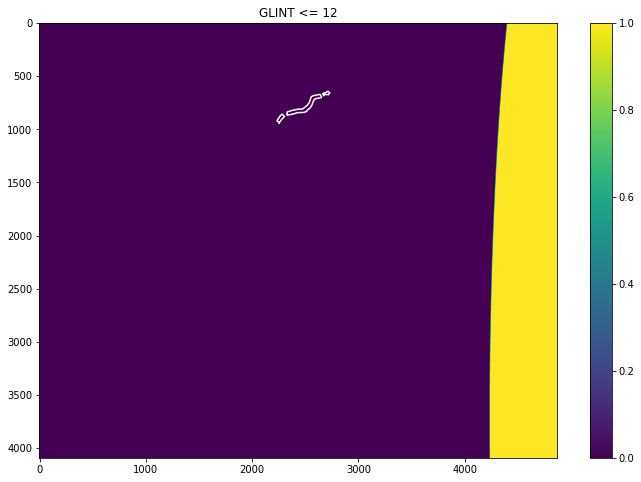

In [77]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.title('GLINT <= 12')
plt.imshow(glint_12)

for vert in xy_vertices:
    plt.plot(vert[:,1],vert[:,0],c='w')

plt.colorbar()
plt.show()

## Animating

In [79]:
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter 

generating mtx: GLINT <= 0º
generating mtx: GLINT <= 1º
generating mtx: GLINT <= 2º
generating mtx: GLINT <= 3º
generating mtx: GLINT <= 4º
generating mtx: GLINT <= 5º
generating mtx: GLINT <= 6º
generating mtx: GLINT <= 7º
generating mtx: GLINT <= 8º
generating mtx: GLINT <= 9º
generating mtx: GLINT <= 10º
generating mtx: GLINT <= 11º
generating mtx: GLINT <= 12º
generating mtx: GLINT <= 13º
generating mtx: GLINT <= 14º
generating mtx: GLINT <= 15º
generating mtx: GLINT <= 16º
generating mtx: GLINT <= 17º
generating mtx: GLINT <= 18º
generating mtx: GLINT <= 19º


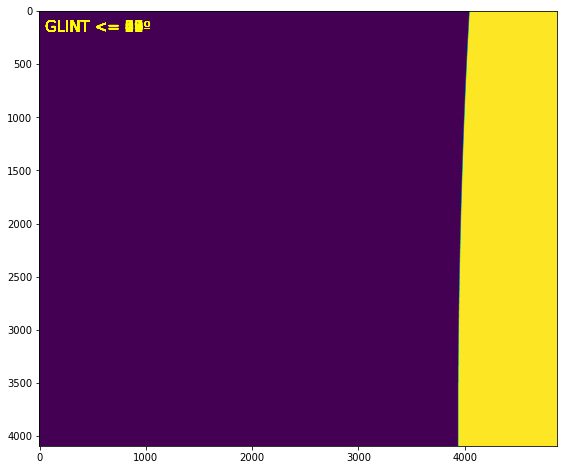

In [89]:
# create a list with all CAMS dates
plt.rcParams['figure.figsize'] = [12, 8]

ims = []
fig = plt.figure("Animation")
ax = fig.add_subplot(111)

for i in range(0,20):
    complete_text = 'GLINT <= '+str(i)+'º'
    print('generating mtx:',complete_text)
    mtx = (glint_mtx <= i).astype(int)
    frame = ax.imshow(mtx)
#     p = ax.plot(xy_vertices[0][:,1],xy_vertices[0][:,0],c='w')
    t = ax.text(50,200,complete_text,color='yellow',fontsize=15) # add text
    ims.append([frame, t])


In [91]:
class LoopingPillowWriter(PillowWriter):
    def finish(self):
        self._frames[0].save(
            self._outfile, save_all=True, append_images=self._frames[1:],
            duration=int(1000 / self.fps), loop=0)

    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=500)

writer = PillowWriter(fps=5)
ani.save('glint_animation.gif', writer=writer)
# ani.save('glint_animation.gif', writer=LoopingPillowWriter(fps=11)) 

plt.show()

01/02/2021 22:56:15 - Animation.save using <class 'matplotlib.animation.PillowWriter'>
